In [12]:
import os
os.environ["HF_HOME"] = "/tmp/wendler/hf_cache"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import argparse
import sys
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

# Add necessary paths for custom modules
sys.path.append("/share/u/wendler/code/my-sdxl-unbox")

from SDLens import HookedStableDiffusionXLPipeline
from SAE import SparseAutoencoder
from utils import add_feature_on_area_turbo

import supervision as sv
import pycocotools.mask as mask_util
from torchvision.ops import box_convert

# Grounded SAM2 and Grounding DINO imports
sys.path.append("/share/u/wendler/code/Grounded-SAM-2")
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from grounding_dino.groundingdino.util.inference import load_model, predict
import grounding_dino.groundingdino.datasets.transforms as T

# Add SDLens/src to sys.path at the top of the scrip

# --- Utility functions ---
def resize_mask(mask, size=(16, 16)):
    return cv2.resize(mask.astype(np.uint8), size, interpolation=cv2.INTER_LANCZOS4) > 0

from matplotlib import pyplot as plt
from typing import Tuple
import grounding_dino.groundingdino.datasets.transforms as T

def sam_mask(img, prompt, sam2_predictor, grounding_model, BOX_THRESHOLD, TEXT_THRESHOLD):
    def load_image(img) -> Tuple[np.array, torch.Tensor]:
        transform = T.Compose(
            [
                T.RandomResize([800], max_size=1333),
                T.ToTensor(),
                T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        )
        image_source = img.convert("RGB")
        image = np.asarray(image_source)
        image_transformed, _ = transform(image_source, None)
        return image, image_transformed
    image_source, image = load_image(img)
    sam2_predictor.set_image(image_source)

    boxes, confidences, labels = predict(
        model=grounding_model,
        image=image,
        caption=prompt,
        box_threshold=BOX_THRESHOLD,
        text_threshold=TEXT_THRESHOLD,
    )

    # process the box prompt for SAM 2
    h, w, _ = image_source.shape
    boxes = boxes * torch.Tensor([w, h, w, h])
    input_boxes = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()


    # FIXME: figure how does this influence the G-DINO model
    # torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

    #if torch.cuda.get_device_properties(0).major >= 8:
        # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
        #torch.backends.cuda.matmul.allow_tf32 = True
        #torch.backends.cudnn.allow_tf32 = True

    masks, scores, logits = sam2_predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_boxes,
        multimask_output=False,
    )

    """
    Post-process the output of the model to get the masks, scores, and logits for visualization
    """
    # convert the shape to (n, H, W)
    if masks.ndim == 4:
        masks = masks.squeeze(1)


    confidences = confidences.numpy().tolist()
    class_names = labels

    class_ids = np.array(list(range(len(class_names))))

    labels = [
        f"{class_name} {confidence:.2f}"
        for class_name, confidence
        in zip(class_names, confidences)
    ]

    detections = sv.Detections(
        xyxy=input_boxes,  # (n, 4)
        mask=masks.astype(bool),  # (n, h, w)
        class_id=class_ids
    )

    box_annotator = sv.BoxAnnotator()
    annotated_frame = box_annotator.annotate(scene=img.copy(), detections=detections)

    label_annotator = sv.LabelAnnotator()
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

    mask_annotator = sv.MaskAnnotator()
    annotated_frame = mask_annotator.annotate(scene=annotated_frame, detections=detections)
    return detections, labels, annotated_frame
    

def best_features_saeuron(cat_feats, dog_feats, k=10):
    mean_cat = cat_feats[0].mean(dim=0)
    mean_dog = dog_feats[0].mean(dim=0)
    scores = mean_cat/mean_cat.sum() - mean_dog/mean_dog.sum()
    arg_sorted = np.argsort(scores.cpu().detach().numpy())
    return arg_sorted[::-1][:k].copy(), arg_sorted[:k].copy()
    #best_features = np.argsort(scores.cpu().detach().numpy())[::-1][:k].copy()
    #return best_features

dtype = torch.float16
device = 'cuda' if torch.cuda.is_available() else 'cpu'
pipe = HookedStableDiffusionXLPipeline.from_pretrained(
    'stabilityai/sdxl-turbo',
    torch_dtype=dtype,
    device_map="balanced",
    variant=("fp16" if dtype==torch.float16 else None)
)
pipe.set_progress_bar_config(disable=True)



Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [124]:
# --- Main experiment ---
def main(prompt1, prompt2, gsam_prompt1, gsam_prompt2, layer, pipe=pipe, k=10,
         n_steps=1, m1=2., m2=0., k_transfer=10, stat1="max", stat2="std", mode="sae"):
    print("[1/9] Loading SDXL pipeline...")

    print("[2/9] Loading SAEs and stats...")
    path_to_checkpoints = '/share/u/wendler/code/my-sdxl-unbox/hparam_study/'
    code_to_block = {
        "down.2.1": "unet.down_blocks.2.attentions.1",
        "up.0.1": "unet.up_blocks.0.attentions.1",
    }
    layer = layer
    if layer not in code_to_block:
        raise ValueError(f"Layer {layer} not recognized. Choose from: {list(code_to_block.keys())}")
    block = code_to_block[layer]
    print(f"Using intervention layer: {layer} k: {k} n_feats: {1*5120:d}(block: {block})")
    sae = SparseAutoencoder.load_from_disk(
        os.path.join(path_to_checkpoints, f"{block}_k{k}_hidden{1*5120:d}_auxk256_bs4096_lr0.0001", "final")
    ).to(device, dtype=dtype)
    means = torch.load(
        os.path.join(path_to_checkpoints, f"{block}_k{k}_hidden{1*5120:d}_auxk256_bs4096_lr0.0001", "final", "mean.pt"),
        weights_only=True
    ).to(device, dtype=dtype)
    stds = torch.load(
        os.path.join(path_to_checkpoints, f"{block}_k{k}_hidden{1*5120:d}_auxk256_bs4096_lr0.0001", "final", "std.pt"),
        weights_only=True
    ).to(device, dtype=dtype)

    print("[3/9] Loading Grounded SAM2 and Grounding DINO...")
    SAM2_CHECKPOINT = "/share/u/wendler/code/Grounded-SAM-2/checkpoints/sam2.1_hiera_large.pt"
    SAM2_MODEL_CONFIG = "configs/sam2.1/sam2.1_hiera_l.yaml"
    GROUNDING_DINO_CONFIG = "/share/u/wendler/code/Grounded-SAM-2/grounding_dino/groundingdino/config/GroundingDINO_SwinT_OGC.py"
    GROUNDING_DINO_CHECKPOINT = "/share/u/wendler/code/Grounded-SAM-2/gdino_checkpoints/groundingdino_swint_ogc.pth"
    BOX_THRESHOLD = 0.35
    TEXT_THRESHOLD = 0.25
    sam2_model = build_sam2(SAM2_MODEL_CONFIG, SAM2_CHECKPOINT, device=device)
    sam2_predictor = SAM2ImagePredictor(sam2_model)
    grounding_model = load_model(
        model_config_path=GROUNDING_DINO_CONFIG,
        model_checkpoint_path=GROUNDING_DINO_CHECKPOINT,
        device=device
    )

    print("[4/9] Generating images and caching activations...")
    seed = 42
    base_imgs1, cache1 = pipe.run_with_cache(
        prompt1,
        positions_to_cache=[block],
        num_inference_steps=1,
        guidance_scale=0.0,
        generator=torch.Generator(device='cpu').manual_seed(seed),
        save_input=True,
    )
    base_imgs2, cache2 = pipe.run_with_cache(
        prompt2,
        positions_to_cache=[block],
        num_inference_steps=1,
        guidance_scale=0.0,
        generator=torch.Generator(device='cpu').manual_seed(seed),
        save_input=True,
    )
    img1 = base_imgs1[0][0]
    img2 = base_imgs2[0][0]

    print("[5/9] Running Grounded SAM on generated images...")
    detections1, labels1, annotated_frame1 = sam_mask(img1, gsam_prompt1, sam2_predictor, grounding_model, BOX_THRESHOLD, TEXT_THRESHOLD)
    detections2, labels2, annotated_frame2 = sam_mask(img2, gsam_prompt2, sam2_predictor, grounding_model, BOX_THRESHOLD, TEXT_THRESHOLD)
    mask1 = resize_mask(detections1.mask[0])
    mask2 = resize_mask(detections2.mask[0])

    print("[6/9] Extracting latents and encoding features...")
    diff1 = cache1['output'][block][0] - cache1['input'][block][0]
    diff2 = cache2['output'][block][0] - cache2['input'][block][0]
    cat = diff1[:, :, mask1]
    dog = diff2[:, :, mask2]
    cat_feats = sae.encode(cat.permute(0, 2, 1))
    dog_feats = sae.encode(dog.permute(0, 2, 1))

    print("[7/9] Selecting best features...")
    k = sae.k
    to_cat_features, to_dog_features = best_features_saeuron(cat_feats, dog_feats, k=k_transfer)
    print(cat_feats.shape)
    # 1 x 39 x 5120
    mean_vals = cat_feats[0].mean(dim=0)[to_cat_features]
    std_vals = cat_feats[0].std(dim=0)[to_cat_features]
    mean_vals = means[to_cat_features]
    std_vals = stds[to_cat_features]
    # make a nice plot with one histogram per feature
    fig, axs = plt.subplots(1, len(to_cat_features), figsize=(15, 5))
    for i, feature in enumerate(to_cat_features):
        axs[i].hist(cat_feats[0][:, feature].cpu().detach().numpy(), bins="rice", edgecolor='black')
        axs[i].set_title(f"Feature {feature}")
        axs[i].set_xlabel("Value")
        axs[i].set_ylabel("Frequency")
    plt.show()

    all_cat_feats = sae.encode(diff1.permute(0, 2, 3, 1))
    # visualize the feature activation maps of the to_cat_features
    plt.imshow(mask1.astype(np.float32))
    plt.show()
    fig, axs = plt.subplots(1, len(to_cat_features), figsize=(15, 5))
    for i, feature in enumerate(to_cat_features):
        axs[i].imshow(mask1.astype(np.float32)*all_cat_feats[0, :,:, feature].cpu().detach().numpy())
        axs[i].set_title(f"Feature {feature}")
    plt.show()

    fig, axs = plt.subplots(1, len(to_cat_features), figsize=(15, 5))
    for i, feature in enumerate(to_cat_features):
        axs[i].imshow((1 - mask1.astype(np.float32))*all_cat_feats[0, :,:, feature].cpu().detach().numpy())
        axs[i].set_title(f"Feature {feature}")
    plt.show()
    print("cat_feats, ", cat_feats[0].shape)
    # use max
    if stat1 == "max":
        stat1_val = cat_feats[0].max(dim=0)[0][to_cat_features]
    elif stat1 == "mean":
        mymeans = []
        print("cat_feats", cat_feats.shape)
        for fidx in to_cat_features:
            coefs = cat_feats[0][..., fidx]
            #mymeans.append(coefs.mean())
            mymeans.append(coefs[coefs > 1e-3].mean())
        stat1_val = torch.tensor(mymeans, device=torch.device("cuda"))
        #stat1_val = cat_feats[torch.abs(cat_feats) > 1e-3]
        #print("stat1 val shape",stat1_val.shape)
        #stat1_val = 0
        #.mean(dim=0)[to_cat_features]
    else:
        ValueError(f"stat1 {stat1} not recognized. Choose from: max, mean")
    print("mean_vals (max)", stat1_val)
    print("std_vals", std_vals)
    print("[8/9] Preparing featuremaps for transfer...")
    fmaps = torch.zeros((1, 16, 16, len(to_cat_features)), device=device)
    fmaps[:, mask2] += (m1*stat1_val + m2*std_vals).unsqueeze(0).unsqueeze(0)

    print("[9/9] Running SDXL with feature injection...")
    def add_featuremaps(sae, to_cat_features, to_dog_features, fmaps, target_mask, module, input, output):
        diff = output[0] - input[0]
        coefs = sae.encode(diff.permute(0, 2, 3, 1))
        mask = torch.zeros([fmaps.shape[0], fmaps.shape[1], fmaps.shape[2], sae.decoder.weight.shape[1]], device=input[0].device)
        mask[0,target_mask][..., to_dog_features] -= coefs[0, target_mask][..., to_dog_features]
        mask[..., to_cat_features] += fmaps.to(mask.device)
        to_add = mask.to(sae.decoder.weight.dtype) @ sae.decoder.weight.T
        return (output[0] + to_add.permute(0, 3, 1, 2).to(output[0].device),)
    
    def activation_patching(sae, mean, target_mask, module, input, output):
        diff = output[0] - input[0]
        diff[0, :, target_mask] = mean[:, None]
        return (diff + input[0],)
    
    def add_featuremaps_deprecated(sae, feature_idcs, fmaps, module, input, output):
        diff = output[0] - input[0]
        coefs = sae.encode(diff.permute(0, 2, 3, 1))
        my_coefs = coefs[..., feature_idcs]
        mask = torch.zeros([fmaps.shape[0], fmaps.shape[1], fmaps.shape[2], sae.decoder.weight.shape[1]], device=input[0].device)
        mask[..., feature_idcs] += fmaps.to(mask.device) - my_coefs
        to_add = mask.to(sae.decoder.weight.dtype) @ sae.decoder.weight.T
        return (output[0] + to_add.permute(0, 3, 1, 2).to(output[0].device),)


    print(sae.decoder.weight.shape)
    print("using mode: ", mode)
    if mode == "patch_max":
        print(cat.shape)
        position_hook_dict={
            block: lambda *args, **kwargs: activation_patching(sae, m1*cat[0].max(dim=1)[0], mask2, *args, **kwargs)
        }
    elif mode == "patch_mean":
        position_hook_dict={
            block: lambda *args, **kwargs: activation_patching(sae, m1*cat[0].mean(dim=1), mask2, *args, **kwargs)
        }
    else:
        position_hook_dict={
            block: lambda *args, **kwargs: add_featuremaps(sae, to_cat_features, to_dog_features, fmaps, mask2, *args, **kwargs)
        }

    result = pipe.run_with_hooks(
        prompt2,
        position_hook_dict=position_hook_dict,
        num_inference_steps=n_steps,
        guidance_scale=0.0,
        generator=torch.Generator(device='cpu').manual_seed(seed)
    ).images[0]

    # make a result figure that shows the images with masks and the intervened image
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Image 1 with mask from prompt 1
    axs[0].imshow(annotated_frame1)
    axs[0].set_title(f"Image with mask: {gsam_prompt1}")
    axs[0].axis('off')
    
    # Image 2 with mask from prompt 2
    axs[1].imshow(annotated_frame2)
    axs[1].set_title(f"Image with mask: {gsam_prompt2}")
    axs[1].axis('off')
    
    # Intervened result image
    axs[2].imshow(result)
    
    plt.show()


[1/9] Loading SDXL pipeline...
[2/9] Loading SAEs and stats...
Using intervention layer: up.0.1 k: 10 n_feats: 5120(block: unet.up_blocks.0.attentions.1)
[3/9] Loading Grounded SAM2 and Grounding DINO...
final text_encoder_type: bert-base-uncased
[4/9] Generating images and caching activations...
[5/9] Running Grounded SAM on generated images...
[6/9] Extracting latents and encoding features...
[7/9] Selecting best features...
torch.Size([1, 39, 5120])


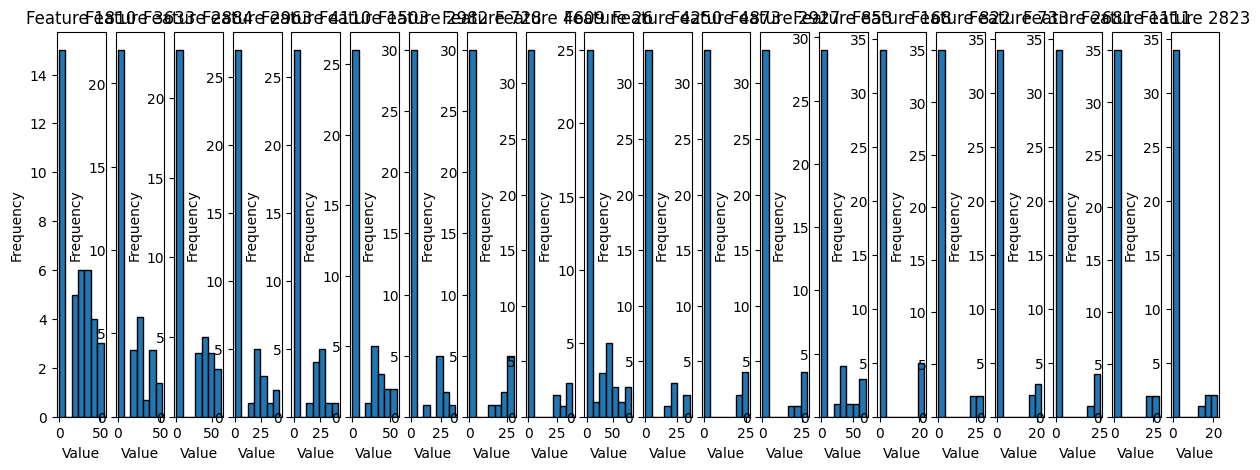

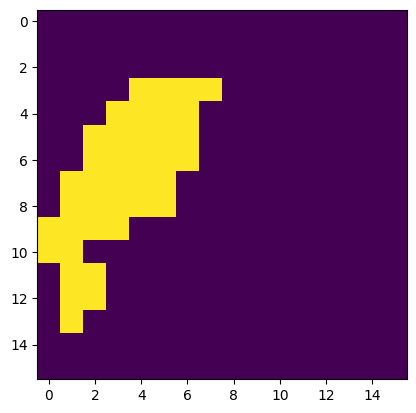

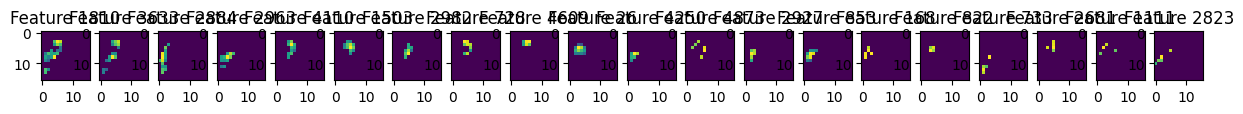

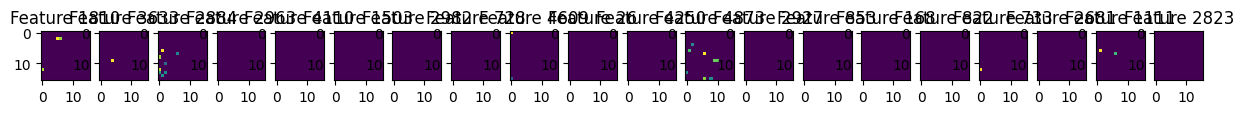

cat_feats,  torch.Size([39, 5120])
cat_feats torch.Size([1, 39, 5120])
mean_vals (max) tensor([32.8750, 30.9062, 43.6562, 27.4844, 26.4844, 37.5625, 25.2188, 24.6719,
        31.0469, 46.8125, 24.6875, 23.5156, 23.4375, 45.0938, 21.8281, 26.4375,
        19.8594, 23.3125, 24.3438, 17.9844], device='cuda:0',
       dtype=torch.float16)
std_vals tensor([13.1797, 11.4609, 19.7344,  7.2422,  5.7148, 18.9219,  8.1406, 11.5781,
        16.2969, 23.4531,  7.5273,  5.8164,  4.3516, 23.0156,  7.9141,  8.1484,
         4.9844,  4.5430,  6.5586,  4.5195], device='cuda:0',
       dtype=torch.float16)
[8/9] Preparing featuremaps for transfer...
[9/9] Running SDXL with feature injection...
torch.Size([1280, 5120])
using mode:  patch_mean


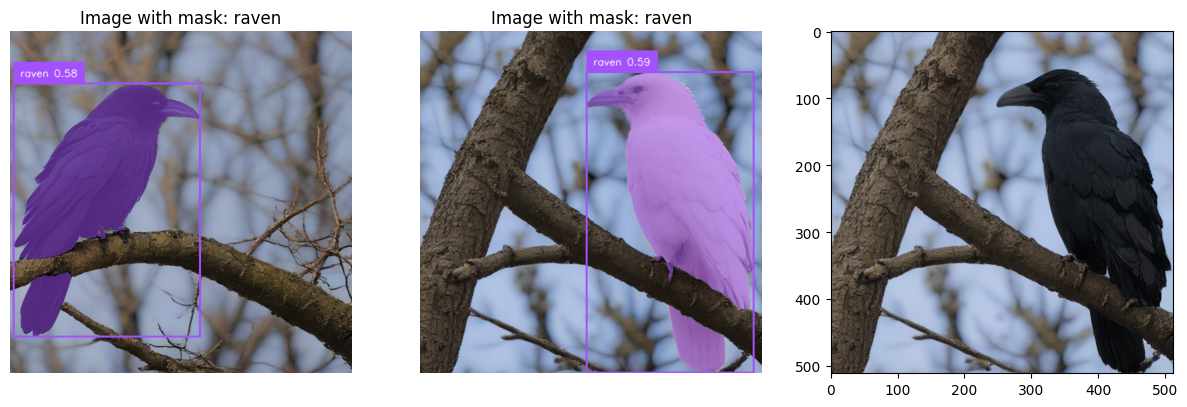

In [126]:
main("a black raven sits on a tree", "a white raven sits on a tree", "raven", "raven", "up.0.1", 
     n_steps=1, m1=2., m2=0., k_transfer=20, stat1="mean", k=10, mode="patch_mean")

[1/9] Loading SDXL pipeline...
[2/9] Loading SAEs and stats...
Using intervention layer: up.0.1 k: 10 n_feats: 5120(block: unet.up_blocks.0.attentions.1)
[3/9] Loading Grounded SAM2 and Grounding DINO...
final text_encoder_type: bert-base-uncased
[4/9] Generating images and caching activations...
[5/9] Running Grounded SAM on generated images...
[6/9] Extracting latents and encoding features...
[7/9] Selecting best features...
torch.Size([1, 168, 5120])


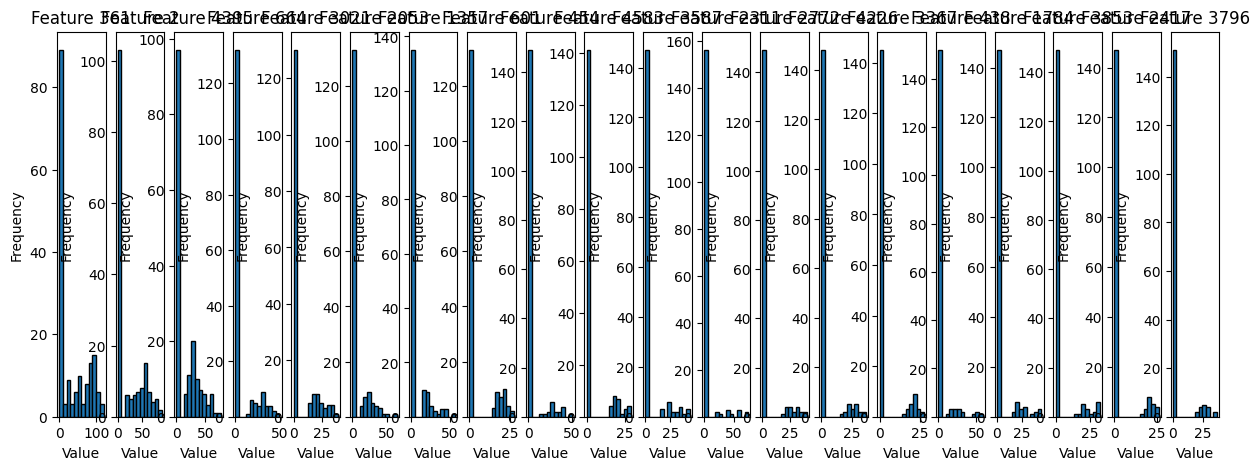

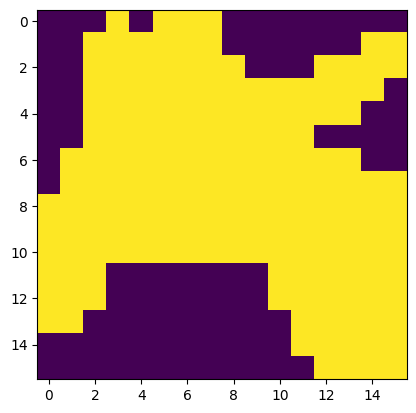

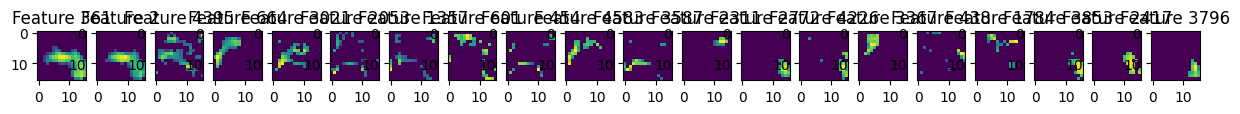

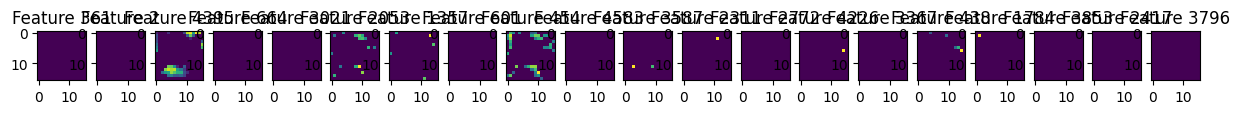

cat_feats,  torch.Size([168, 5120])
cat_feats torch.Size([1, 168, 5120])
mean_vals (max) tensor([68.8750, 50.6250, 35.8438, 29.3125, 23.6562, 27.6250, 26.3750, 20.2656,
        31.7031, 21.1250, 29.3594, 46.2188, 27.9531, 25.9219, 21.3906, 30.5000,
        27.7500, 24.7344, 21.7500, 26.7344], device='cuda:0',
       dtype=torch.float16)
std_vals tensor([23.9531, 18.8750, 22.0312, 15.2109, 12.3984,  7.9453,  7.4219,  8.3594,
        10.0703, 17.1875,  6.5898, 26.1719,  6.6523,  5.1211, 12.2891,  6.3477,
         8.6797,  4.1250,  3.9570,  6.2148], device='cuda:0',
       dtype=torch.float16)
[8/9] Preparing featuremaps for transfer...
[9/9] Running SDXL with feature injection...
torch.Size([1280, 5120])
using mode:  patch_mean


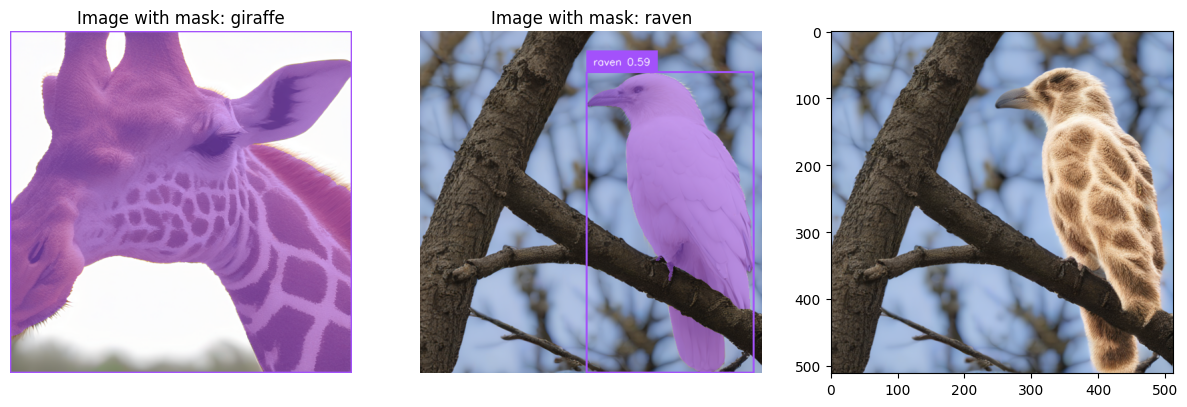

In [ ]:
main("a photo of a giraffe", "a white raven sits on a tree", "giraffe", "raven", "up.0.1", 
     n_steps=1, m1=2., m2=0., k_transfer=20, stat1="mean", k=10, mode="patch_mean")

[1/9] Loading SDXL pipeline...
[2/9] Loading SAEs and stats...
Using intervention layer: up.0.1 k: 10 n_feats: 5120(block: unet.up_blocks.0.attentions.1)
[3/9] Loading Grounded SAM2 and Grounding DINO...
final text_encoder_type: bert-base-uncased
[4/9] Generating images and caching activations...
[5/9] Running Grounded SAM on generated images...
[6/9] Extracting latents and encoding features...
[7/9] Selecting best features...
torch.Size([1, 168, 5120])


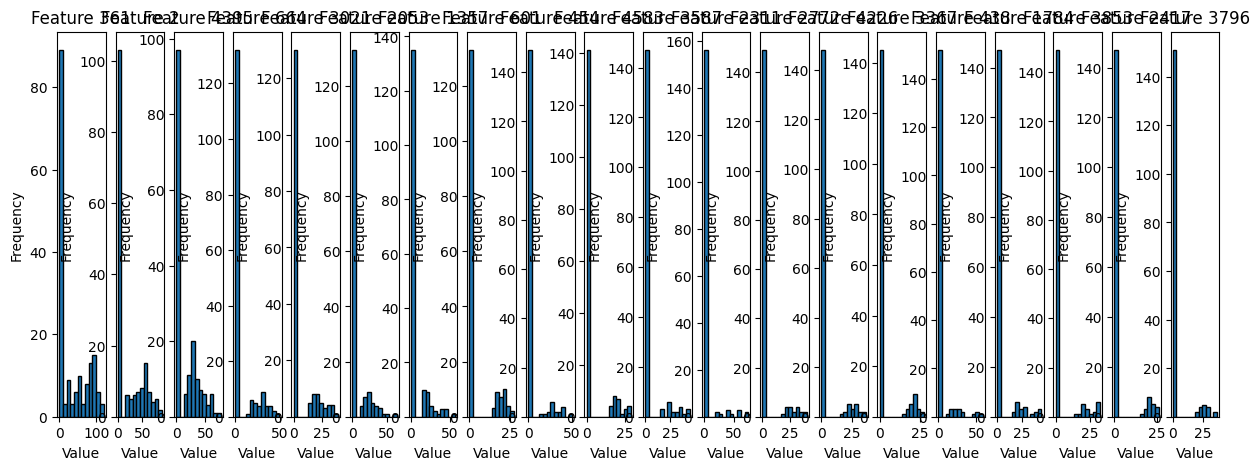

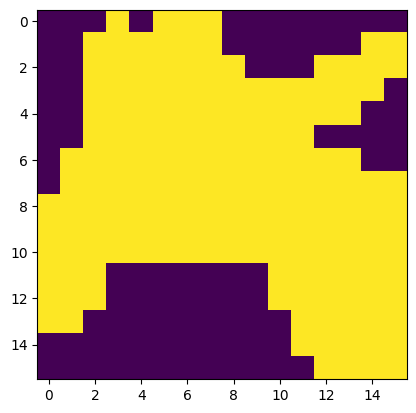

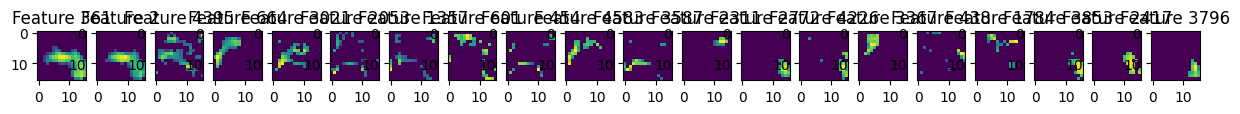

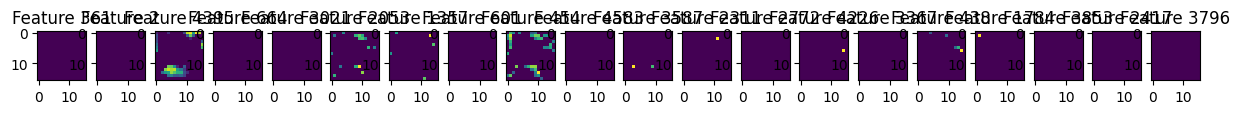

cat_feats,  torch.Size([168, 5120])
cat_feats torch.Size([1, 168, 5120])
mean_vals (max) tensor([68.8750, 50.6250, 35.8438, 29.3125, 23.6562, 27.6250, 26.3750, 20.2656,
        31.7031, 21.1250, 29.3594, 46.2188, 27.9531, 25.9219, 21.3906, 30.5000,
        27.7500, 24.7344, 21.7500, 26.7344], device='cuda:0',
       dtype=torch.float16)
std_vals tensor([23.9531, 18.8750, 22.0312, 15.2109, 12.3984,  7.9453,  7.4219,  8.3594,
        10.0703, 17.1875,  6.5898, 26.1719,  6.6523,  5.1211, 12.2891,  6.3477,
         8.6797,  4.1250,  3.9570,  6.2148], device='cuda:0',
       dtype=torch.float16)
[8/9] Preparing featuremaps for transfer...
[9/9] Running SDXL with feature injection...
torch.Size([1280, 5120])
using mode:  sae


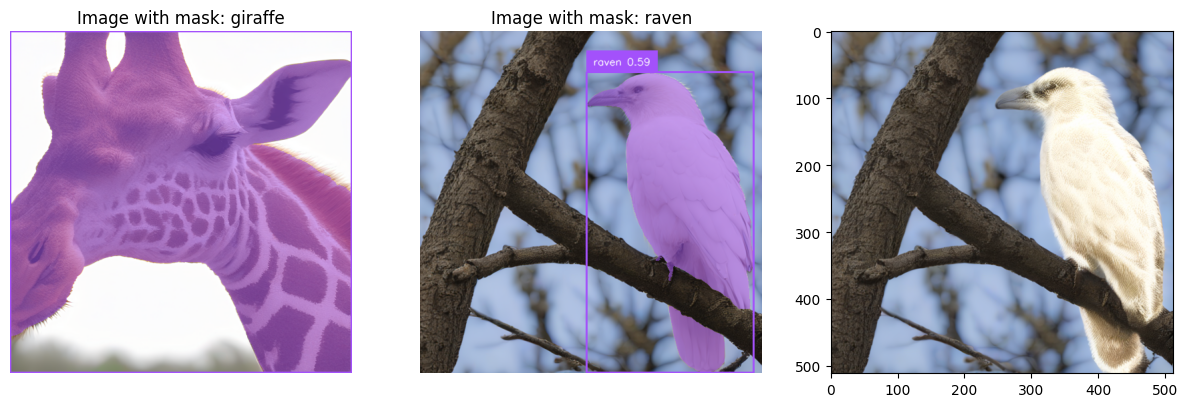

In [132]:
main("a photo of a giraffe", "a white raven sits on a tree", "giraffe", "raven", "up.0.1", 
     n_steps=1, m1=2., m2=0., k_transfer=20, stat1="mean", k=10, mode="sae")

[1/9] Loading SDXL pipeline...
[2/9] Loading SAEs and stats...
Using intervention layer: down.2.1 k: 160 n_feats: 5120(block: unet.down_blocks.2.attentions.1)
[3/9] Loading Grounded SAM2 and Grounding DINO...
final text_encoder_type: bert-base-uncased
[4/9] Generating images and caching activations...
[5/9] Running Grounded SAM on generated images...
[6/9] Extracting latents and encoding features...
[7/9] Selecting best features...
torch.Size([1, 150, 5120])


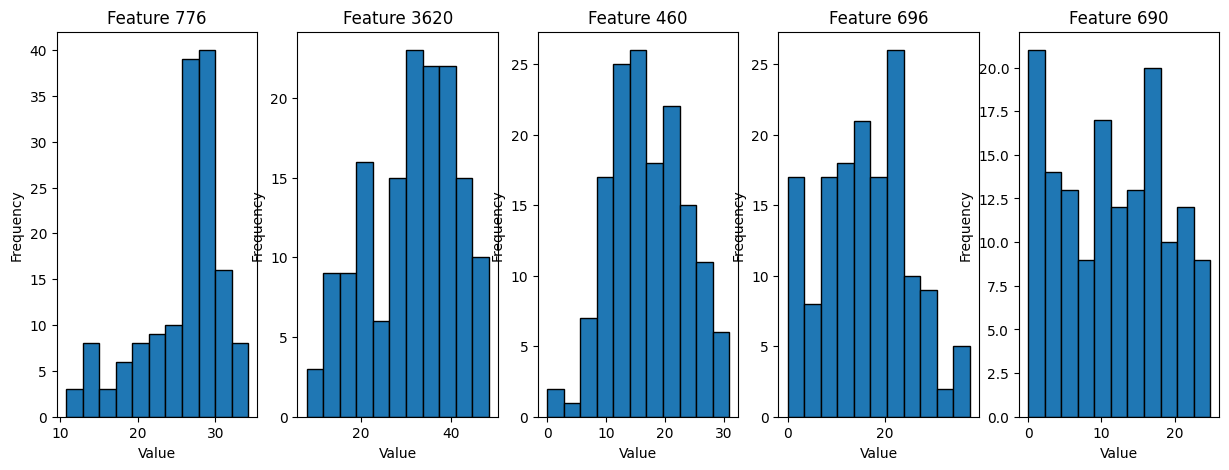

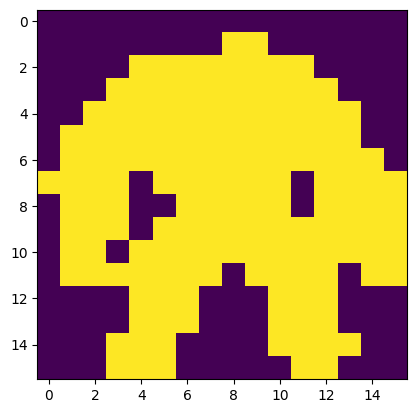

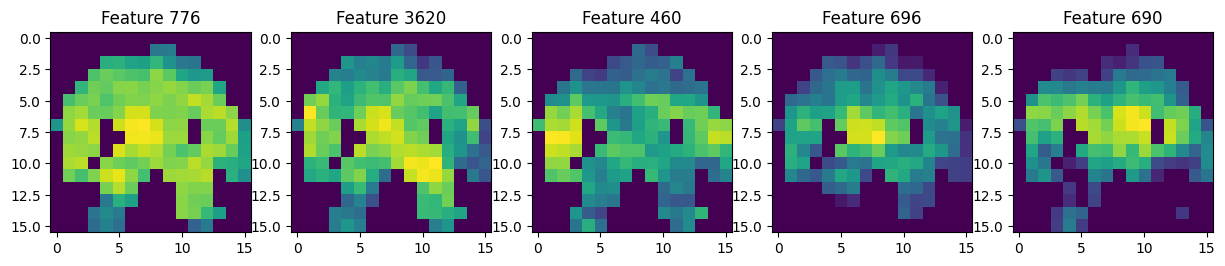

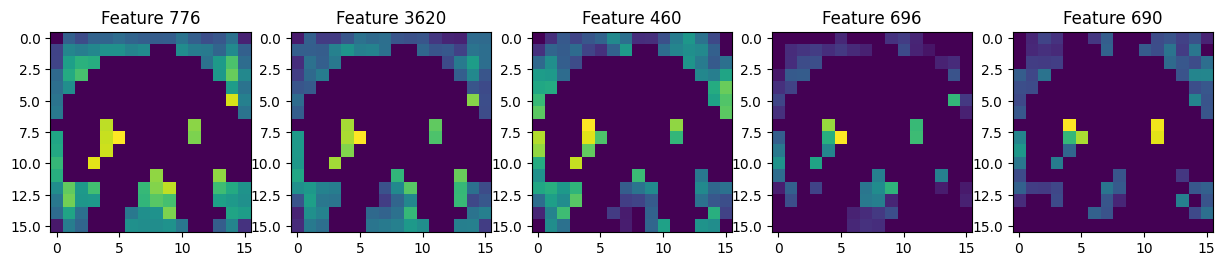

cat_feats,  torch.Size([150, 5120])
mean_vals (max) tensor([34.2500, 48.5000, 30.9531, 37.4688, 24.8438], device='cuda:0',
       dtype=torch.float16, grad_fn=<IndexBackward0>)
std_vals tensor([2.9727, 8.4609, 7.6758, 4.4141, 3.1719], device='cuda:0',
       dtype=torch.float16)
[8/9] Preparing featuremaps for transfer...
[9/9] Running SDXL with feature injection...
torch.Size([1280, 5120])
using mode:  patch_mean


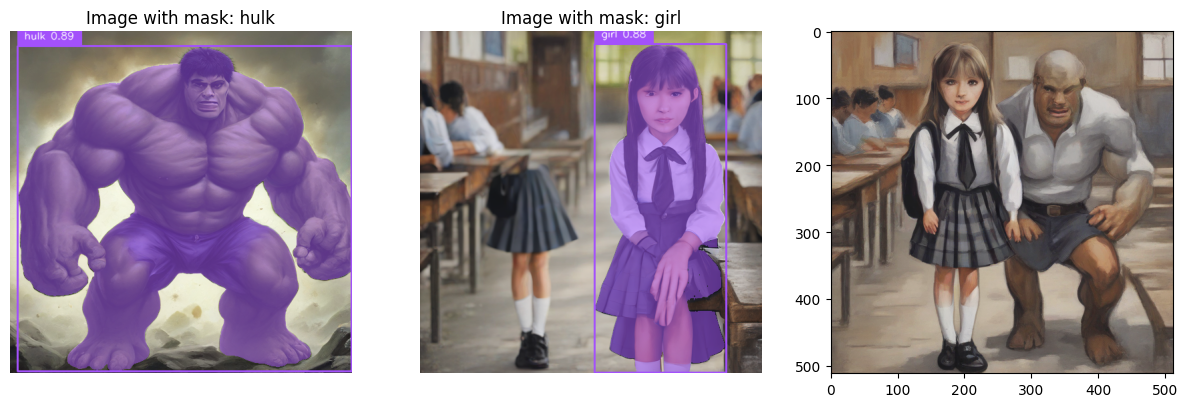

In [136]:
main("the powerful hulk ", "a schoolgirl", "hulk", "girl", "down.2.1", 
     n_steps=1, m1=2., m2=0., k_transfer=5, stat1="max", k=160, mode="patch_mean")

[1/9] Loading SDXL pipeline...
[2/9] Loading SAEs and stats...
Using intervention layer: up.0.1 k: 5 n_feats: 5120(block: unet.up_blocks.0.attentions.1)
[3/9] Loading Grounded SAM2 and Grounding DINO...
final text_encoder_type: bert-base-uncased
[4/9] Generating images and caching activations...
[5/9] Running Grounded SAM on generated images...
[6/9] Extracting latents and encoding features...
[7/9] Selecting best features...
torch.Size([1, 111, 5120])


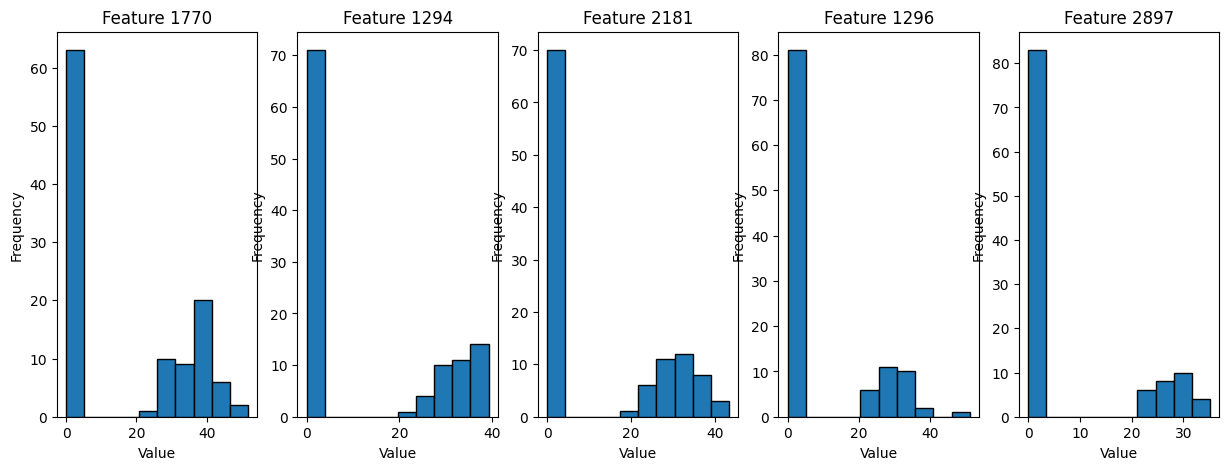

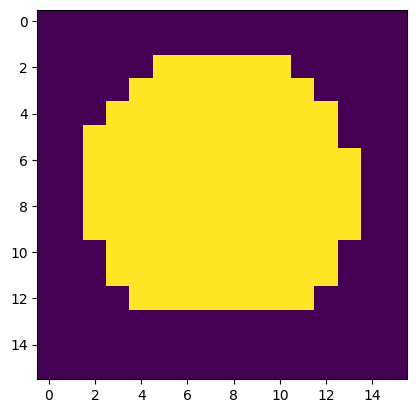

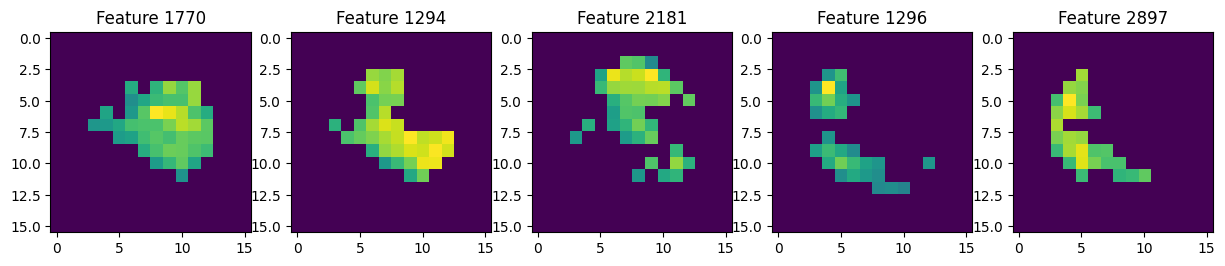

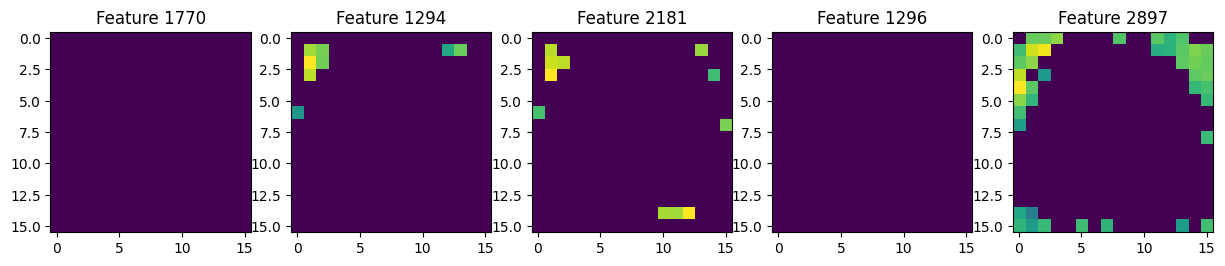

cat_feats,  torch.Size([111, 5120])
mean_vals (max) tensor([51.8125, 39.2500, 43.4062, 51.2812, 35.2188], device='cuda:0',
       dtype=torch.float16, grad_fn=<IndexBackward0>)
std_vals tensor([ 9.1562, 16.4531,  9.4219,  7.6797, 13.6719], device='cuda:0',
       dtype=torch.float16)
[8/9] Preparing featuremaps for transfer...
[9/9] Running SDXL with feature injection...
torch.Size([1280, 5120])
using mode:  patch_mean


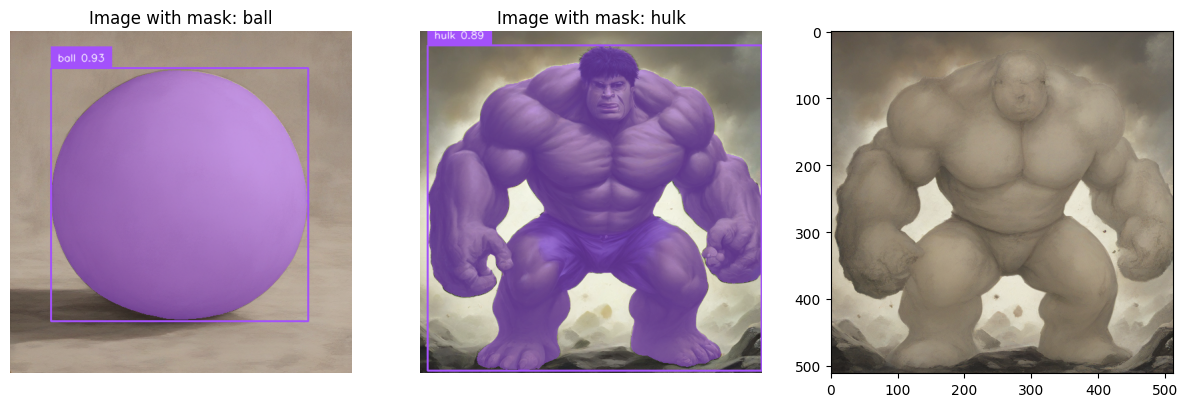

In [137]:
main("a round ball ", "a the powerful hulk", "ball", "hulk", "up.0.1", #"down.2.1", 
     n_steps=1, m1=1., m2=0., k_transfer=5, stat1="max", k=5, mode="patch_mean")